<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation using KernelSHAP for weather prediction regressor
This notebook demonstrates the use of DIANNA with the [KernelSHAP](https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) explainer method for next day temperature predictor (regressor) on a [weather dataset](https://zenodo.org/records/10580833) containing tabular data of the temperatures from several locations in Europe.

#### Colab setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]

#### 0 - Libraries

In [2]:
import dianna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from dianna.utils.onnx_runner import SimpleModelRunner
from dianna.utils.downloader import download

from numba.core.errors import NumbaDeprecationWarning
import warnings
# silence the Numba deprecation warnings in shap
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

#### 1 - Loading the data
Load weather prediction dataset.

In [3]:
data = pd.read_csv(download('weather_prediction_dataset_light.csv', 'data'))

#### Prepare the data
As the target, the sunshine hours for the next day in the data-set will be used. Therefore, we will remove the last data point as this has no target. A tabular regression model will be trained which does not require time-based data, therefore DATE and MONTH can be removed.

In [4]:
X_data = data.drop(columns=['DATE', 'MONTH'])[:-1]
y_data = data.loc[1:]["BASEL_sunshine"]

Training, validation, and test data split.

In [5]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X_data, y_data, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=0)

Get an instance to explain.

In [6]:
# get an instance from test data
data_instance = X_test.iloc[10].to_numpy()

#### 2 - Loading ONNX model
DIANNA supports ONNX models. Here we demonstrate the use of KernelSHAP explainer for tabular data with a pre-trained ONNX model, which is a MLP regressor for the weather dataset. The model is trained following this [notebook](https://github.com/dianna-ai/dianna-exploration/blob/main/example_data/model_generation/sunshine_prediction/generate_model.ipynb).

In [7]:
# load onnx model and check the prediction with it
model_path = download('sunshine_hours_regression_model.onnx', 'model')
loaded_model = SimpleModelRunner(model_path)
predictions = loaded_model(data_instance.reshape(1,-1).astype(np.float32))
predictions

array([[3.0719438]], dtype=float32)

A runner function is created to prepare data for the ONNX inference session.

In [8]:
import onnxruntime as ort

def run_model(data):
    # get ONNX predictions
    sess = ort.InferenceSession(model_path)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

#### 3 -  Applying KernelSHAP with DIANNA
The simplest way to run DIANNA on tabular data is with `dianna.explain_tabular`.

DIANNA requires input in numpy format, so the input data is converted into a numpy array.

Note that the training data is also required since KernelSHAP needs it to generate proper perturbation.

In [9]:
explanation = dianna.explain_tabular(run_model, input_tabular=data_instance, method='kernelshap',
                                     mode ='regression', training_data = X_train, 
                                     training_data_kmeans = 5, feature_names=X_test.columns)

#### 4 - Visualization
The output can be visualized with the DIANNA built-in visualization function. It shows the top 10 importance of each feature contributing to the prediction.

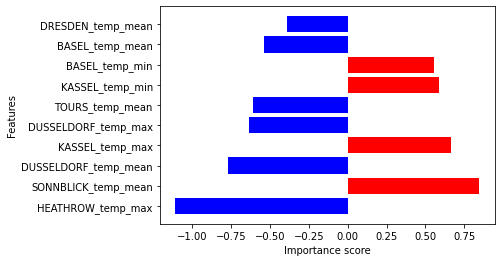

In [10]:
from dianna.visualization import plot_tabular

fig, _ = plot_tabular(explanation, X_test.columns, num_features=10)